### Import modules and training data

In [1]:
#import modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label

%matplotlib inline

# import training data
car_images = glob.glob('vehicles/*/*.png')
notcar_images = glob.glob('non-vehicles/*/*.png')

8792
8968
(64, 64, 3)


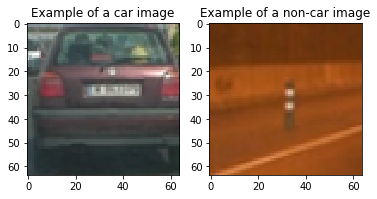

In [2]:
print(len(car_images))
print(len(notcar_images))

car_img = mpimg.imread(car_images[1800])
plt.subplot(1,2,1)
plt.imshow(car_img)
plt.title('Example of a car image')
print(car_img.shape)
noncar_img = mpimg.imread(notcar_images[6100])
plt.subplot(1,2,2)
plt.imshow(noncar_img)
plt.title('Example of a non-car image')

plt.savefig('examples/car_notcar.png')

### Functions for HOG, spatial and color histogram feature extraction

In [3]:
# Define functions for feature extraction
# Most of the functions have been directly adapted from code shown in the lectures

# Histogram of Oriented Gradients
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis==True:
        features, hog_vis = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis,
                                feature_vector=feature_vec)
        return features, hog_vis
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                      cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, visualise=False,
                      feature_vector=feature_vec)
        return features

# Function to convert image to a different colorspace
def convertColor(img, color_space):
    imgcp = np.copy(img)
    colorDict = {'cv2.COLOR_RGB2BGR':cv2.COLOR_RGB2BGR, 'cv2.COLOR_RGB2HSV':cv2.COLOR_RGB2HSV, 'cv2.COLOR_RGB2HLS':cv2.COLOR_RGB2HLS, 
                 'cv2.COLOR_RGB2YCrCb':cv2.COLOR_RGB2YCrCb}
    cvspace = 'cv2.COLOR_RGB2'+color_space
    if color_space != 'RGB':
        imgcp = cv2.cvtColor(imgcp, colorDict[cvspace])
    return imgcp

# For spatial binning of color
def bin_spatial(img, color_space='RGB', size=(32,32), convColor=True):
    imgcp = np.copy(img)
    if convColor==True:
        imgcp = convertColor(imgcp, color_space)
    features = cv2.resize(imgcp, size).ravel()
    return features, imgcp

# Histogram of color as a feature
def color_hist(img, hist_bins=32, hist_range=(0,256)):
    ch1_hist = np.histogram(img[:,:,0], bins=hist_bins, range=hist_range)
    ch2_hist = np.histogram(img[:,:,1], bins=hist_bins, range=hist_range)
    ch3_hist = np.histogram(img[:,:,2], bins=hist_bins, range=hist_range)
    features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return features


### Functions to extract features from a single image and a list of images

In [4]:
# This call functions for spatial binning, HOG feature extraction and color histogram extraction
def single_img_features(img, cspace='RGB', size=(32,32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', vis=False):
    img_features = []
    spatial_features, imgcp = bin_spatial(img, cspace, size)
    img_features.append(spatial_features)
    hist_features = color_hist(imgcp, hist_bins)
    img_features.append(hist_features)
    #imgcp = convertColor(img, cspace)
    
    if hog_channel=='ALL':
        hog_features = []
        for channel in range(imgcp.shape[2]):
            hog_features.extend(get_hog_features(imgcp[:,:,channel], orient, pix_per_cell, cell_per_block))
    else:
        if vis==True:
            hog_features, hog_vis = get_hog_features(imgcp[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True)
        else:
            hog_features = get_hog_features(imgcp[:,:,hog_channel], orient, pix_per_cell, cell_per_block)
    img_features.append(hog_features)
    
    #Return concatenation of the different feature arrays
    if vis==True:
        return np.concatenate(img_features), hog_vis
    else:
        return np.concatenate(img_features)

def extract_features(images, cspace='RGB', size=(32,32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    features = []
    for file in images:
        #img = cv2.imread(file)
        img = mpimg.imread(file)
        features.append(single_img_features(img, cspace, size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel))
    return features
        

### Visualize HOG features from a single image

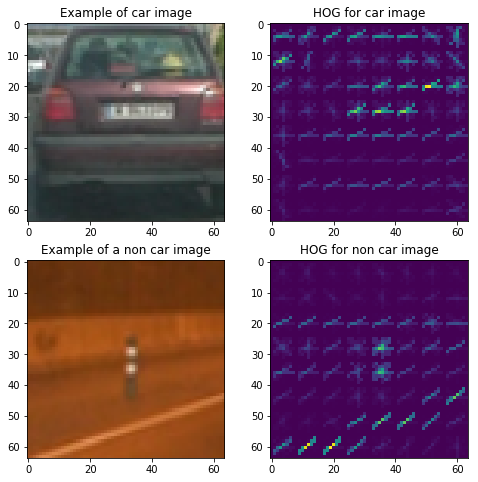

In [24]:
# Extract features from a single image and visualize HOG features
cspace1 = 'YCrCb' 
spatialsize1 = (32,32)
histbin1 = 32
orient1 = 8
pix_p_cell = 8
cell_p_block = 2
hog_channel1 = 0

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(car_img)
plt.title('Example of car image')
single_features, hog_vis = single_img_features(car_img, cspace1, spatialsize1, histbin1, orient1, pix_p_cell, cell_p_block, hog_channel1, vis=True)
plt.subplot(2,2,2)
plt.imshow(hog_vis)
plt.title('HOG for car image')
plt.subplot(2,2,3)
plt.imshow(noncar_img)
plt.title('Example of a non car image')
single_features, hog_vis = single_img_features(noncar_img, cspace1, spatialsize1, histbin1, orient1, pix_p_cell, cell_p_block, hog_channel1, vis=True)
plt.subplot(2,2,4)
plt.imshow(hog_vis)
plt.title('HOG for non car image')
plt.savefig('examples/hog_image.png')

### Feature extraction for car and noncar image data

In [5]:
# Feature extraction parameters
color_space = 'YCrCb'
spatial_size = (32,32)
histbin = 32
orient = 9
pix_per_cell = 8
cell_per_block  = 2
hog_channel = 'ALL'

car_features = extract_features(car_images, color_space, spatial_size, histbin, orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_features(notcar_images, color_space, spatial_size, histbin, orient, pix_per_cell, cell_per_block, hog_channel)


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Run classification

In [6]:
# Train model
from sklearn.cross_validation import train_test_split
import time

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaledX = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split dataset into training and test sets randomly
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaledX, y, test_size=0.2, random_state=rand_state)

# Train linear SVC
svc = LinearSVC()
params_dict = {"C":np.logspace(-4,1,6)}
search = GridSearchCV(estimator=svc, param_grid=params_dict)
t = time.time()
#svc.fit(X_train, y_train)
search.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print("Best parameter values:", search.best_params_)
print("CV Score with best parameter values:", search.best_score_)

best_svm = search.best_estimator_
best_svm.fit(X_train, y_train)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


192.54 Seconds to train SVC...
Best parameter values: {'C': 0.0001}
CV Score with best parameter values: 0.98902027027


LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [7]:
# test data accuracy
#print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(best_svm.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9918


### Sliding window search

In [8]:
# This code block is a modified version of the code for detection as shown in the lecture modules
# function to find rectangles that have been predicted to contain cars
def find_cars(img, y_start, y_stop, x_start, x_stop, scale, svc, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel, colorDisp=(0,0,255)):
    rectangles = []
    
    draw_img = np.copy(img)
    
    img_tosearch = img.astype(np.float32)/255
    # Limit search area to the boundaries passed in
    img_tosearch = img_tosearch[y_start:y_stop,x_start:x_stop,:]
    convImg = convertColor(img_tosearch, cspace)
    
    # Rescale image to adjust window size effectively
    if scale!=1.0:
        convImg = cv2.resize(convImg, (np.int(convImg.shape[1]/scale), np.int(convImg.shape[0]/scale)))
    
    ch1 = convImg[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel=='ALL':
        ch2 = convImg[:,:,1]
        ch3 = convImg[:,:,2]
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    else:
        ch1 = convImg[:,:,hog_channel]
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel=='ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch          
            subimg = convImg[ytop:ytop+window, xleft:xleft+window,:]            
            
            # draw test windows on image
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img, (xbox_left+x_start, ytop_draw+y_start),(xbox_left+win_draw+x_start,ytop_draw+y_start+win_draw),colorDisp,6)
            
            
            # Get color features
            spatial_features, subimgcp = bin_spatial(subimg, cspace, size=spatial_size, convColor=False)
            hist_features = color_hist(subimg, hist_bins=hist_bins)
            
            #normalized test features
            test_features = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(test_features.reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left+x_start, ytop_draw+y_start),(xbox_left+win_draw+x_start,ytop_draw+win_draw+y_start)))
    return rectangles, draw_img


### Run pipeline on test images

4


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


20


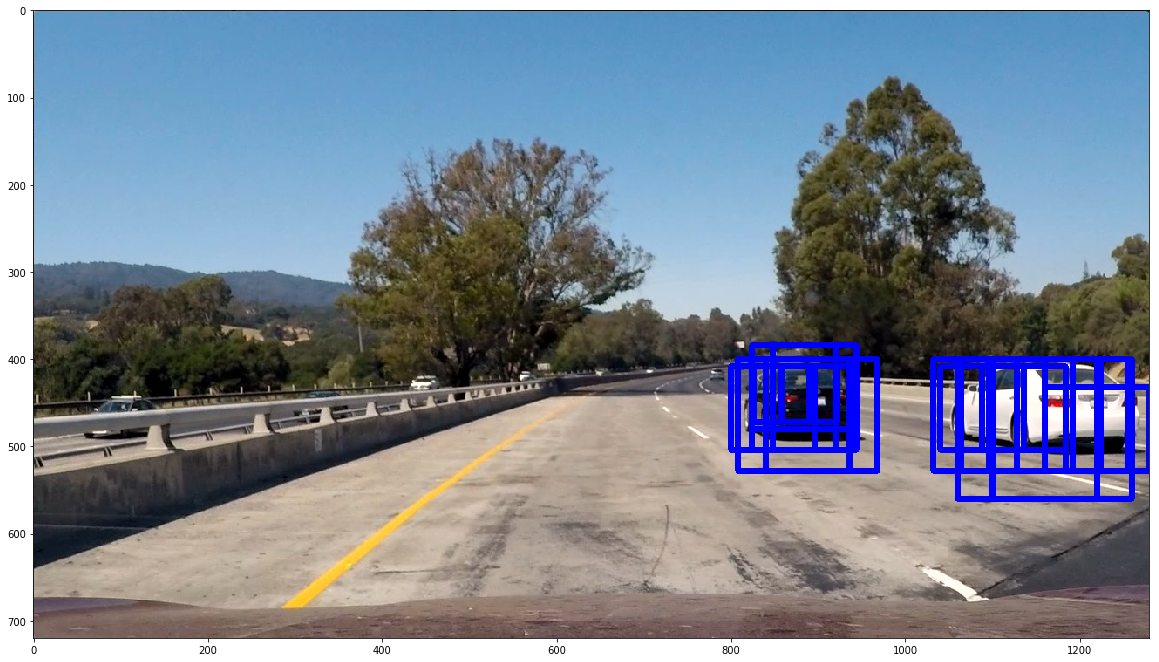

In [9]:

all_rectangles = []
test_img = mpimg.imread('test_images/test1.jpg')

windowDict = [{'y_start':360,'y_stop':520, 'x_start':250, 'x_stop':1250, 'scale':1.0},{'y_start':360,'y_stop':620,'x_start':200,'x_stop':1280,'scale':1.5},
              {'y_start':400,'y_stop':680,'x_start':200,'x_stop':1280,'scale':2.0}, {'y_start':400,'y_stop':700,'x_start':100,'x_stop':1280,'scale':2.5}]

colorDisp = [(0,0,255), (0,255,0), (255,0,0), (0,255,255), (255,255,0), (255,0,255),(255,255,255)]

plt.figure(figsize=(20,20))
print(len(windowDict))
for i in range(len(windowDict)):
    rectangles, draw_img = find_cars(test_img, windowDict[i]['y_start'], windowDict[i]['y_stop'], windowDict[i]['x_start'], windowDict[i]['x_stop'],windowDict[i]['scale'], best_svm, color_space, orient, pix_per_cell, cell_per_block, spatial_size, histbin, hog_channel)
    all_rectangles.extend(rectangles)
    #plt.subplot(4,1,i+1)
    #plt.imshow(draw_img)
#plt.savefig('examples/slide_window.png')

out_img = np.copy(test_img)
print(len(all_rectangles))
for i in range(len(all_rectangles)):
    cv2.rectangle(out_img,all_rectangles[i][0], all_rectangles[i][1],(0,0,255),6)
#plt.subplot(8,1,8)
plt.imshow(out_img)


### Generate bounding box from heatmap

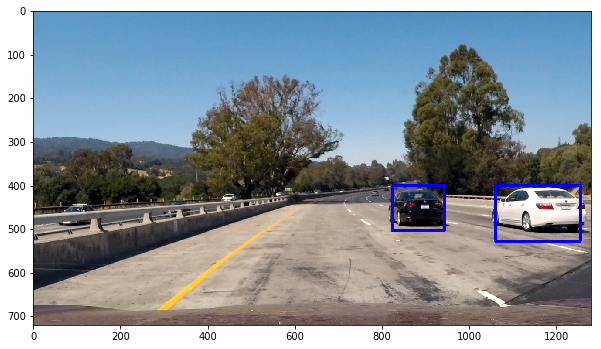

In [10]:
# Heat Map
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def find_labeled_boxes(img, labels):
    bboxlist = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxlist.append((bbox[0],bbox[1]))
    # Return the image
    return bboxlist

def draw_boxes(img, bboxlist):
    for i in range(len(bboxlist)):
        cv2.rectangle(img, bboxlist[i][0], bboxlist[i][1], (0,0,255), 6)
    return img

heat = add_heat(heat, all_rectangles)
heat = apply_threshold(heat, 2)
heatmap = np.clip(heat, 0, 255)
plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)
#plt.imshow(heatmap, cmap='gray')

labels = label(heatmap)
bboxlist = find_labeled_boxes(test_img, labels)
draw_img = draw_boxes(np.copy(test_img), bboxlist)
plt.imshow(draw_img)
'''
plt.figure(figsize=(35,35))
plt.subplot(1,4,1)
plt.imshow(test_img)
plt.title('Input image',fontsize=25)
plt.subplot(1,4,2)
plt.imshow(out_img)
plt.title('Windows detected',fontsize=25)
plt.subplot(1,4,3)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap',fontsize=25)
plt.subplot(1,4,4)
plt.imshow(draw_img)
plt.title('Final detection box',fontsize=25)

plt.savefig('examples/detection.png')
'''
plt.savefig('output_images/test1.png')

### Test Pipeline on Video

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
# Define a class 'Detect' to hold information from car detections in previous video frames
class Detect():
    def __init__(self, n=5):
        self.num_frames = 0
        self.last_heatmap = None
        self.last_n_heatmap = []
        self.max_frames = n
        
    def add(self, heat):
        self.last_n_heatmap.append(heat)
        if (len(self.last_n_heatmap) > self.max_frames):
            self.last_n_heatmap = self.last_n_heatmap[1:]
            
    def sumHeat(self):
        return sum(self.last_n_heatmap)

prevDect = Detect(10)

### Define function to process each frame

In [23]:

count = 0
threshold = 9
color_space = 'YCrCb'
def process_image(img):
    
    all_rects = []
    for i in range(len(windowDict)):
        rects, dimg = find_cars(img, windowDict[i]['y_start'], windowDict[i]['y_stop'], windowDict[i]['x_start'], windowDict[i]['x_stop'],windowDict[i]['scale'], best_svm, color_space, orient, pix_per_cell, cell_per_block, spatial_size, histbin, hog_channel)
        all_rects.extend(rects)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_rects)

    prevDect.add(heat)
    heat = prevDect.sumHeat()
        
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
        
    labels = label(heatmap)
    bboxlist = find_labeled_boxes(img, labels)
    bboxlist_total = bboxlist
    
    draw_img = draw_boxes(np.copy(img), bboxlist_total)
        
    prevDect.num_frames += 1
    
    return draw_img

def process_individual_frame(img):
    all_rects = []
    for i in range(len(windowDict)):
        rects, dimg = find_cars(img, windowDict[i]['y_start'], windowDict[i]['y_stop'], windowDict[i]['x_start'], windowDict[i]['x_stop'],windowDict[i]['scale'], best_svm, color_space, orient, pix_per_cell, cell_per_block, spatial_size, histbin, hog_channel)
        all_rects.extend(rects)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_rects)
    return all_rects, heat

In [47]:
output_vid = 'test_video_out.mp4'

# First run on a shorter subclip for testing 
#clip1 = VideoFileClip('test_video.mp4').subclip(0,5)
clip1 = VideoFileClip('test_video.mp4')
print(clip1.fps)
processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_vid, audio=False)

25.0
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:45<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 43.1 s, sys: 2.53 s, total: 45.6 s
Wall time: 47.1 s


In [14]:
proj_out_vid = 'project_video_out.mp4'

#clip1 = VideoFileClip('project_video.mp4').subclip(40,48)
clip1 = VideoFileClip('project_video.mp4')
processed_clip = clip1.fl_image(process_image)
%time processed_clip.write_videofile(proj_out_vid, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [25:27<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 24min 19s, sys: 1min 10s, total: 25min 30s
Wall time: 25min 28s


### Extract frames to debug

In [42]:
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = 'project_video.mp4'
imgdir = 'frames'
times = 48.8, 49, 49.5, 49.8

extract_frames(movie, times, imgdir)
    

### Extract 6 consecutive frames

In [22]:
cvid = cv2.VideoCapture('project_video.mp4')
cvid.set(cv2.CAP_PROP_POS_FRAMES, 912) #look at frames starting at 907
success, img = cvid.read()
if success:
    cv2.imwrite('frames/project_video_frame6.jpg', img)
    cv2.imshow('912', img)
cvid.release()

### Video frames and corresponding heatmaps

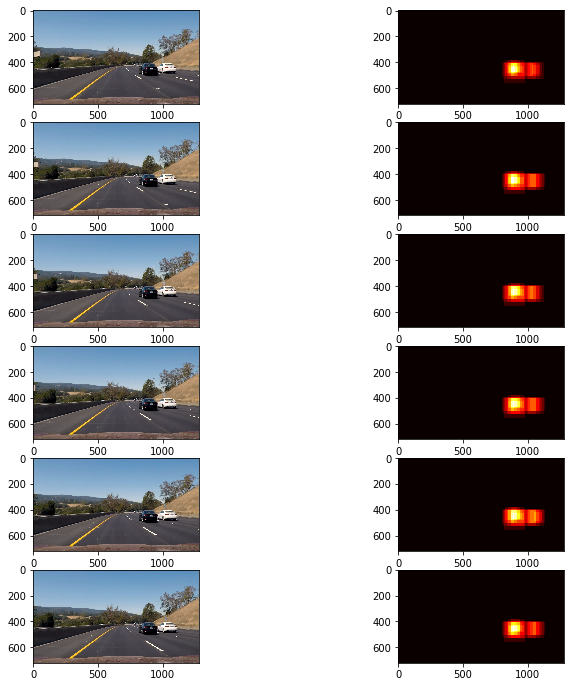

In [30]:
frames = glob.glob('frames/project_video_frame*.jpg')
count_frame = 1
plt.figure(figsize=(12,12))
detection = Detect(6)
for file in frames:
    img = mpimg.imread(file)
    rects, heatmap = process_individual_frame(img)
    detection.add(heatmap)
    plt.subplot(6,2,count_frame)
    plt.imshow(img)
    plt.subplot(6,2,count_frame+1)
    plt.imshow(heatmap, cmap='hot')
    count_frame += 2
plt.savefig('examples/frame_heat.png')
plt.show()

### Sum heatmaps across frames

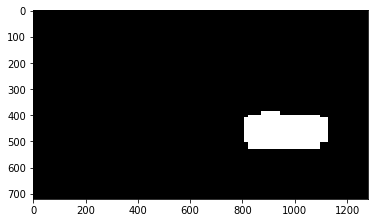

In [31]:
heat = detection.sumHeat()
        
heat = apply_threshold(heat, threshold)
heatmap = np.clip(heat, 0, 255)
        
labels = label(heatmap)
plt.imshow(labels[0], cmap='gray')
plt.savefig('labeled_frames.png')

### Image with bounding box for final detection

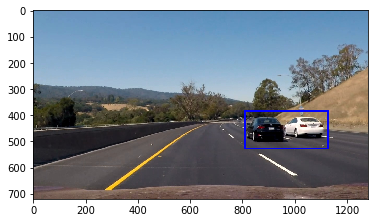

In [32]:
bboxlist = find_labeled_boxes(img, labels)
bboxlist_total = bboxlist
    
draw_img = draw_boxes(np.copy(img), bboxlist_total)
plt.imshow(draw_img)
plt.savefig('img_with_bbox.png')